
# Entrega 3
**Novedad:** limite 170k


In [2]:
import os, math, warnings, csv, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from inspect import signature
import sklearn

RANDOM_STATE = 42
warnings.filterwarnings("ignore")
print("scikit-learn:", sklearn.__version__)


scikit-learn: 1.7.2



## 1) Carga robusta del CSV + normalización numérica


In [3]:

CSV_PATH = r"../integrador/include/data/processed/propiedades_clean.csv"
assert Path(CSV_PATH).exists(), f"No se encontró el archivo: {CSV_PATH}"

def load_csv_robust(path:str) -> pd.DataFrame:
    import pandas as pd, csv
    # UTF-8 con autodetección
    try:
        return pd.read_csv(path, engine="python", sep=None, quoting=csv.QUOTE_MINIMAL, on_bad_lines="skip", encoding="utf-8")
    except Exception:
        # Latin-1 con autodetección
        try:
            return pd.read_csv(path, engine="python", sep=None, quoting=csv.QUOTE_MINIMAL, on_bad_lines="skip", encoding="latin-1")
        except Exception:
            # separadores comunes
            for sep_try in [",",";","|","\t"]:
                try:
                    return pd.read_csv(path, engine="python", sep=sep_try, quoting=csv.QUOTE_MINIMAL, on_bad_lines="skip", encoding="utf-8")
                except Exception:
                    pass
            raise

df_raw = load_csv_robust(CSV_PATH)
print("Shape leído:", df_raw.shape)
display(df_raw.head(3))

# Normalización numérica: convierte strings tipo "1.234.567,89" -> 1234567.89
def normalize_numeric_like(s: pd.Series) -> pd.Series:
    if s.dtype != object:
        return s
    t = s.astype(str).str.strip()
    t = t.str.replace(r"[\u00A0\s]", "", regex=True)
    # si tiene coma decimal, quitar puntos de miles
    t = t.apply(lambda x: x.replace(".", "") if ("," in x and x.count(",")==1) else x)
    t = t.str.replace(",", ".", regex=False)
    # eliminar puntos de miles residuales ####.###
    t = t.str.replace(r"(?<=\d)\.(?=\d{3}(\D|$))", "", regex=True)
    num = pd.to_numeric(t, errors="coerce")
    return num if num.notna().mean() >= 0.3 else s

df_norm = df_raw.copy()
for col in df_norm.columns:
    df_norm[col] = normalize_numeric_like(df_norm[col])

print("Dtypes (primeras 20):")
display(df_norm.dtypes.head(20))


Shape leído: (6822, 21)


,﻿propiedad_id,tip_desc,prp_dom,loc_desc,pro_desc,con_desc,grupo_tip_desc,prp_pre_dol,prp_pre,banos,...,cochera,sup_total,sup_cubierta,prp_alta,prp_mod,url_ficha_inmoup,prp_lat,prp_lng,fotos_cantidad,cocheras
0,1,Casa,Juan Pobre 296,Capital,Mendoza,Venta,casas,249000.0,0.0,3.0,...,1,600.0,210.0,2025-10-04 12:51:06,2025-10-05 17:28:05,https://inmoup.com.ar/311145-cesar-arturo-cort...,-32.87052748595013,-68.8850326348242,6,NaN
1,2,Casa,sanchez 2632,Guaymallen,Mendoza,Alquiler,casas,0.0,525000.0,1.0,...,1,635.0,150.0,2025-10-07 19:32:46,2025-10-07 19:40:58,https://inmoup.com.ar/311300-metrocuadrado/inm...,-32.8943687749218,-68.73450162566226,6,NaN
2,3,Casa,Calle Genova,Godoy Cruz,Mendoza,Venta,casas,680000.0,0.0,3.0,...,1,450.0,700.0,2025-09-05 16:56:27,2025-09-17 14:39:17,https://inmoup.com.ar/273442-paula-correas-inm...,-32.95762532740413,-68.86596622803346,11,NaN


Dtypes (primeras 20):


propiedad_id         int64
tip_desc             object
prp_dom              object
loc_desc             object
pro_desc             object
con_desc             object
grupo_tip_desc       object
prp_pre_dol         float64
prp_pre             float64
banos               float64
dormitorios         float64
cochera               int64
sup_total           float64
sup_cubierta        float64
prp_alta             object
prp_mod              object
url_ficha_inmoup     object
prp_lat             float64
prp_lng             float64
fotos_cantidad        int64
dtype: object


## 2) Filtro de negocio opcional (≤ 170k) **y saneo de target**
- Remueve NaN/±inf/≤0 en `prp_pre_dol` antes del split.


In [4]:
TARGET_COL = "prp_pre_dol"
APLICAR_FILTRO_170K = True  # Cambiar a False si querés todo el rango

df = df_norm.copy()
assert TARGET_COL in df.columns, f"Falta {TARGET_COL}"

# Convertir a numérico
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# Filtro de negocio (si aplica)
if APLICAR_FILTRO_170K:
    before = len(df)
    df = df[df[TARGET_COL].le(170_000)]
    print(f"Filtro ≤170k: {len(df)}/{before} filas ({100*len(df)/before:.1f}%).")

# --- Saneo del target ---
n_before = len(df)
mask_valid = df[TARGET_COL].notna() & np.isfinite(df[TARGET_COL]) & (df[TARGET_COL] > 0)
dropped = n_before - mask_valid.sum()
df = df[mask_valid].copy()

print(f"Saneo target: eliminadas {dropped} filas con NaN/±inf/≤0. Total: {len(df)}")
display(df[TARGET_COL].describe(percentiles=[.25,.5,.75,.9,.95]).to_frame().T)


Filtro ≤170k: 4655/6822 filas (68.2%).
Saneo target: eliminadas 421 filas con NaN/±inf/≤0. Total: 4234


,count,mean,std,min,25%,50%,75%,90%,95%,max
prp_pre_dol,4234.0,69346.141474,45471.520729,1.0,30000.0,65000.0,100000.0,140000.0,150000.0,170000.0



## 3) Detección de fecha y split temporal 80/20


In [5]:

CANDIDATE_DATES = [c for c in df.columns if any(k in c.lower() for k in ["fecha","alta","public"])]
date_col = None
for c in CANDIDATE_DATES:
    conv = pd.to_datetime(df[c], errors="coerce")
    if conv.notna().sum() > 0:
        date_col = c
        break

y = df[TARGET_COL].astype(float)
X = df.drop(columns=[TARGET_COL])

if date_col is not None:
    X["_split_date"] = pd.to_datetime(X[date_col], errors="coerce")
    order = X["_split_date"].fillna(pd.Timestamp.min).argsort().values
    cutoff = int(len(X)*0.8)
    idx_train, idx_test = order[:cutoff], order[cutoff:]
    X_train, X_test = X.iloc[idx_train].drop(columns=["_split_date"]), X.iloc[idx_test].drop(columns=["_split_date"])
    y_train, y_test = y.iloc[idx_train], y.iloc[idx_test]
    cutoff_date = X.iloc[idx_train[-1]][date_col]
    print(f"Train: {X_train.shape} | Test: {X_test.shape} | Corte: {pd.to_datetime(cutoff_date).date() if pd.notna(cutoff_date) else '(sin fecha)'}")
    use_timeseries_cv = True
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train: {X_train.shape} | Test: {X_test.shape} | Split aleatorio (sin fecha)")
    use_timeseries_cv = False

# Validación extra: sin NaN en y_train/y_test
assert y_train.notna().all() and np.isfinite(y_train).all(), "y_train contiene NaN/inf"
assert y_test.notna().all() and np.isfinite(y_test).all(), "y_test contiene NaN/inf"


Train: (3387, 20) | Test: (847, 20) | Corte: 2025-09-16



## 4) Feature engineering seguro + winsorización


In [6]:

class SafeFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, lat_col='prp_lat', lng_col='prp_lng', sup_total='sup_total',
                 sup_cubierta='sup_cubierta', dormitorios='dormitorios', banos='banos',
                 fotos='fotos_cantidad', n_geo_clusters=8, random_state=42):
        self.lat_col = lat_col
        self.lng_col = lng_col
        self.sup_total = sup_total
        self.sup_cubierta = sup_cubierta
        self.dormitorios = dormitorios
        self.banos = banos
        self.fotos = fotos
        self.n_geo_clusters = n_geo_clusters
        self.random_state = random_state
        self.kmeans_ = None
        self.geo_available_ = False

    @staticmethod
    def _safe_num(s):
        return pd.to_numeric(s, errors="coerce")

    def _valid_geo_mask(self, df):
        lat = self._safe_num(df.get(self.lat_col))
        lng = self._safe_num(df.get(self.lng_col))
        if lat is None or lng is None:
            return None
        return lat.notna() & lng.notna() & (lat.between(-90,90)) & (lng.between(-180,180))

    def fit(self, X, y=None):
        X = X.copy()
        mask = self._valid_geo_mask(X)
        self.geo_available_ = mask is not None and mask.sum() >= self.n_geo_clusters
        if self.geo_available_:
            pts = pd.DataFrame({'lat': self._safe_num(X[self.lat_col]), 'lng': self._safe_num(X[self.lng_col])})[mask]
            self.kmeans_ = KMeans(n_clusters=self.n_geo_clusters, random_state=self.random_state, n_init=10)
            self.kmeans_.fit(pts)
        return self

    def transform(self, X):
        X = X.copy()
        num = self._safe_num

        # logs
        if self.sup_cubierta in X.columns:
            X['log_sup_cubierta'] = np.log1p(num(X[self.sup_cubierta]))
        if self.sup_total in X.columns:
            X['log_sup_total'] = np.log1p(num(X[self.sup_total]))
        if self.fotos in X.columns:
            X['log_fotos'] = np.log1p(num(X[self.fotos]))

        # ratios
        if all(c in X.columns for c in [self.sup_cubierta, self.sup_total]):
            st = num(X[self.sup_total]); sc = num(X[self.sup_cubierta])
            X['ratio_cubierta'] = np.where(st>0, sc/st, np.nan)

        if all(c in X.columns for c in [self.dormitorios, self.banos, self.sup_cubierta]):
            amb = num(X[self.dormitorios]).fillna(0) + num(X[self.banos]).fillna(0)
            denom = np.log1p(num(X[self.sup_cubierta]))
            X['ambientes_m2'] = np.where(denom>0, amb/denom, np.nan)

        # geo clusters
        mask = self._valid_geo_mask(X)
        if self.kmeans_ is not None and mask is not None and mask.sum()>0:
            pts = pd.DataFrame({'lat': num(X[self.lat_col]), 'lng': num(X[self.lng_col])})
            labels = np.full(len(X), np.nan)
            labels[mask] = self.kmeans_.predict(pts[mask])
            X['geo_cluster'] = pd.Series(labels, index=X.index).astype('category')
        else:
            X['geo_cluster'] = pd.Series(np.nan, index=X.index).astype('category')
        return X


In [7]:

class WinsorizeNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            s = pd.to_numeric(X[col], errors="coerce")
            lo, hi = s.quantile(self.lower), s.quantile(self.upper)
            self.bounds_[col] = (lo, hi)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lo, hi) in self.bounds_.items():
            if col in X.columns:
                X[col] = pd.to_numeric(X[col], errors="coerce").clip(lower=lo, upper=hi)
        return X



## 5) Pipeline y modelos


In [8]:

numeric_selector = selector(dtype_include=np.number)
categorical_selector = selector(dtype_include=['object', 'category'])

ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in signature(OneHotEncoder.__init__).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("winsor", WinsorizeNumeric(0.01, 0.99)),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(**ohe_kwargs)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_selector),
        ("cat", categorical_transformer, categorical_selector),
    ],
    remainder="drop",
)

def build_pipeline(estimator):
    return Pipeline(steps=[
        ("feat", SafeFeatureEngineer()),
        ("prep", preprocess),
        ("model", TransformedTargetRegressor(
            regressor=estimator,
            func=np.log1p,
            inverse_func=np.expm1,
            check_inverse=False,
        )),
    ])

pipe_rf  = build_pipeline(RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=300, n_jobs=-1))
pipe_hgb = build_pipeline(HistGradientBoostingRegressor(random_state=RANDOM_STATE))


## 6) Benchmark con CV

Se habilita `FAST_BENCHMARK` para correr esta sección en modo rápido (3 folds y muestra capada). Cambiá a `False` si necesitás el barrido completo (5 folds sobre todo el set).


In [9]:
import math

FAST_BENCHMARK = False   # Cambiar a False para modo completo
FAST_FOLDS = 3
FAST_SAMPLE_CAP = 4000

use_temporal_cv = ('date_col' in globals() and date_col is not None)

if use_temporal_cv:
    n_splits = FAST_FOLDS if FAST_BENCHMARK else 5
    n_splits = max(2, min(n_splits, max(2, len(X_train) - 1)))
    cv_obj = TimeSeriesSplit(n_splits=n_splits)
else:
    cv_obj = FAST_FOLDS if FAST_BENCHMARK else 5

X_cv = X_train
y_cv = y_train

if FAST_BENCHMARK:
    if FAST_SAMPLE_CAP and len(X_train) > FAST_SAMPLE_CAP:
        if use_temporal_cv:
            X_cv = X_train.tail(FAST_SAMPLE_CAP)
            y_cv = y_train.iloc[-FAST_SAMPLE_CAP:]
        else:
            sample_idx = X_train.sample(FAST_SAMPLE_CAP, random_state=RANDOM_STATE).index
            X_cv = X_train.loc[sample_idx]
            y_cv = y_train.loc[sample_idx]
    if use_temporal_cv:
        print(f"Benchmark rápido temporal: {len(X_cv)} filas, {cv_obj.n_splits} folds.")
    else:
        folds = cv_obj if isinstance(cv_obj, int) else FAST_FOLDS
        print(f"Benchmark rápido: {len(X_cv)} filas, {folds} folds.")
else:
    if use_temporal_cv:
        print(f"Benchmark completo temporal con {cv_obj.n_splits} folds sobre {len(X_cv)} filas.")
    else:
        folds = cv_obj if isinstance(cv_obj, int) else 5
        print(f"Benchmark completo: {folds} folds sobre {len(X_cv)} filas.")

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
}

def evaluate_pipe(pipe, name):
    cvres = cross_validate(
        pipe,
        X_cv,
        y_cv,
        scoring=scoring,
        cv=cv_obj,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise',
    )
    out = {
        'modelo': name,
        'rmse_cv': -cvres['test_rmse'].mean(),
        'rmse_cv_std': cvres['test_rmse'].std(),
        'mae_cv': -cvres['test_mae'].mean(),
        'r2_cv': cvres['test_r2'].mean(),
        'rmse_train': -cvres['train_rmse'].mean(),
        'r2_train': cvres['train_r2'].mean(),
    }
    return out

rows = []
for pipe, name in [
    (pipe_rf, "RandomForestRegressor"),
    (pipe_hgb, "HistGradientBoostingRegressor"),
]:
    rows.append(evaluate_pipe(pipe, name))

results_df = pd.DataFrame(rows).sort_values("rmse_cv")
display(results_df)


Benchmark completo temporal con 5 folds sobre 3387 filas.


,modelo,rmse_cv,rmse_cv_std,mae_cv,r2_cv,rmse_train,r2_train
0,RandomForestRegressor,29822.720107,1855.842598,21288.014749,0.564051,11997.185204,0.929602
1,HistGradientBoostingRegressor,32959.514805,7489.618991,22847.871113,0.446958,17966.670216,0.840612



## 7) Tuning del mejor


In [10]:

best_name = results_df.iloc[0]["modelo"]
print("Mejor modelo para tuning:", best_name)

if best_name == "RandomForestRegressor":
    base = pipe_rf
    param_distributions = {
        'model__regressor__n_estimators': [200, 300, 400, 600],
        'model__regressor__max_depth': [10, 12, 15, None],
        'model__regressor__min_samples_split': [2, 5, 10],
        'model__regressor__min_samples_leaf': [1, 2, 5, 10],
        'model__regressor__max_features': [0.3, 0.5, 0.7, 1.0],
    }
else:
    base = pipe_hgb
    param_distributions = {
        'model__regressor__learning_rate': [0.05, 0.1, 0.2],
        'model__regressor__max_depth': [None, 6, 10],
        'model__regressor__min_samples_leaf': [10, 20, 30],
        'model__regressor__l2_regularization': [0.0, 0.1, 1.0],
        'model__regressor__max_bins': [255],
    }

search = RandomizedSearchCV(
    base,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5) if ('date_col' in globals() and date_col is not None) else 5,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
    error_score='raise',
)
search.fit(X_train, y_train)
print("Mejores hiperparámetros:", search.best_params_)
print("RMSE CV (best):", -search.best_score_)
best_pipe = search.best_estimator_


Mejor modelo para tuning: RandomForestRegressor
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperparámetros: {'model__regressor__n_estimators': 200, 'model__regressor__min_samples_split': 2, 'model__regressor__min_samples_leaf': 1, 'model__regressor__max_features': 0.5, 'model__regressor__max_depth': None}
RMSE CV (best): 29686.969529450766



## 8) Evaluación final + tasa de error


In [12]:
def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    import math
    return math.sqrt(mean_squared_error(y_true, y_pred))

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

rmse_test = rmse(y_test, y_pred)
mae_test  = mean_absolute_error(y_test, y_pred)
r2_test   = r2_score(y_test, y_pred)

print(f"RMSE test: {rmse_test:,.2f}")
print(f"MAE  test: {mae_test:,.2f}")
print(f"R2   test: {r2_test:.3f}")

rel_error = 100 * rmse_test / (y_test.mean() if y_test.mean() != 0 else 1)
print(f"Tasa de error relativa (RMSE / media precio test): {rel_error:.1f}%")


RMSE test: 29,386.80
MAE  test: 20,803.85
R2   test: 0.598
Tasa de error relativa (RMSE / media precio test): 41.7%



## 9) Diagnóstico visual


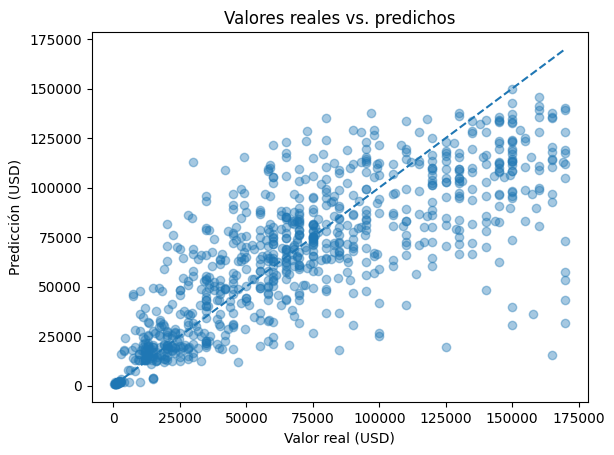

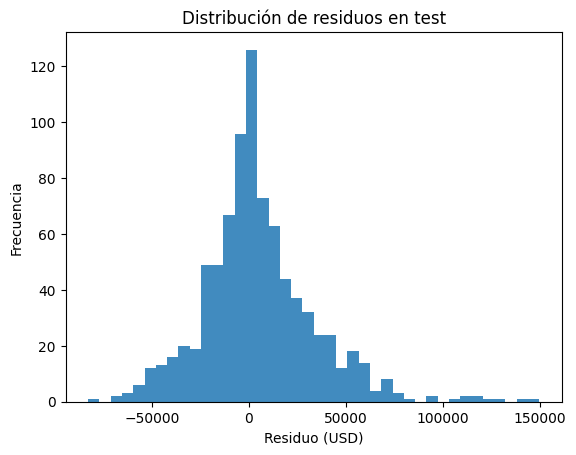

In [13]:

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel("Valor real (USD)")
plt.ylabel("Predicción (USD)")
plt.title("Valores reales vs. predichos")

plt.figure()
res = y_test - y_pred
plt.hist(res, bins=40, alpha=0.85)
plt.xlabel("Residuo (USD)")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuos en test")
plt.show()
